In [1]:
"""
심화 학습: 선형 회귀 (linear regression)

회귀 작업의 좋은 시작점
매우 빠르게 적합, 해석하기가 아주 쉬움
직선 데이터에 적합시킴
""";

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np, seaborn as sns; sns.set()

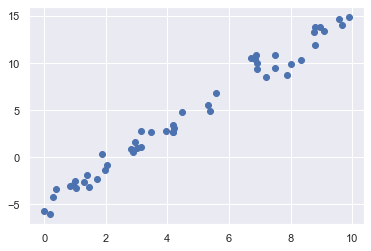

In [3]:
# 단순 선형 회귀 (y = ax + b)
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

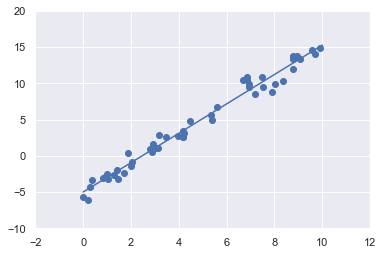

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, None])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(-2, 12)
plt.ylim(-10, 20);

In [5]:
# LinearRegression 모델 모수 (coef_, intercept_)
print("Model slope: ", model.coef_[0])
print("Model intercept: ", model.intercept_)

Model slope:  2.0272088103606944
Model intercept:  -4.9985770855532


In [6]:
# LinearRegression 추정기로 다차원 직선 모델 처리
# y = a0 + a1x1 + a2x2 + ...
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.]) # y는 임의의 x값 3개로부터 구성

model.fit(X, y) # LinearRegression 추정기를 사용해 선이나 면, 초평면을 데이터에 적합
print(model.intercept_)
print(model.coef_)

0.5000000000000033
[ 1.5 -2.   1. ]


In [7]:
# 기저 함수 회귀 (basis function)
# y = a0 + a1x1 + a2x2 + a3x3 + ...
# fn(x) = x^n => y = a0 + a1x + a2x^2 + a3x^3 + ...
# 여전히 선형 모델 (계수 a_n이 서로 곱하거나 나누지 않음)

# 다항식 기저 함수 (polynomial basis function)
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [8]:
# 파이프라인 사용, 7차 다항식 모델 만들기
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

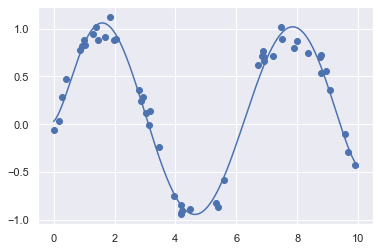

In [9]:
# 노이즈가 섞인 Sine 곡선
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, None], y)
y_fit = poly_model.predict(xfit[:, None])

plt.scatter(x, y)
plt.plot(xfit, y_fit);

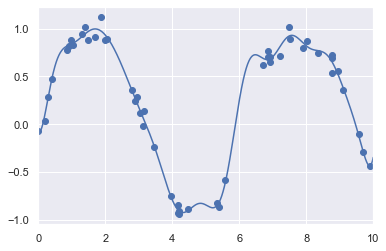

In [10]:
# 가우스 기저 함수 (Gaussian basis function)
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """ 1차원 입력에 대해 균일한 간격을 가지는 가우시안 특징 """
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
        
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        # 데이터 범위를 따라 펼쳐진 N개의 중앙점 생성
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, None], self.centers_,
                                 self.width_, axis=1)

gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, None], y)
y_fit = gauss_model.predict(xfit[:, None])

plt.scatter(x, y)
plt.plot(xfit, y_fit)
plt.xlim(0,10);

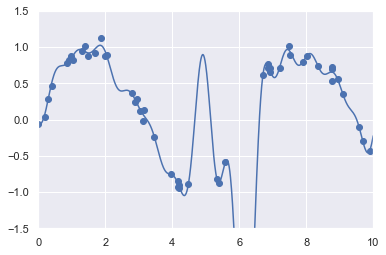

In [11]:
# 정규화 (Normalization)
# 기저 함수를 선형 회귀에 도입하면 모델이 유연해지지만, 매우 빠르게 과적합될 수 있다
# 너무 많은 가우스 기저 함수를 선택하면 보기에 그다지 좋지 않은 결과
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, None], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, None]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

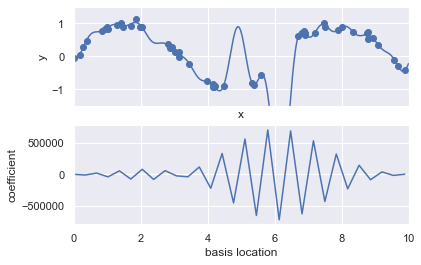

In [12]:
# 가우스 기저 함수의 계수를 위치별로 플로팅
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, 1, sharex=True)
    model.fit(x[:, None], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, None]))
    ax[0].set(xlabel="x", ylabel="y", ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)
    ax[1].plot(model.steps[0][1].centers_, model.steps[1][1].coef_)
    ax[1].set(xlabel="basis location",
              ylabel="coefficient",
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

# ax[1], 아래쪽 그림은 각 위치별 기저 함수의 진폭을 보여준다.
# 기저 함수가 겹칠 때 나타나는 전형적인 과적합 행위

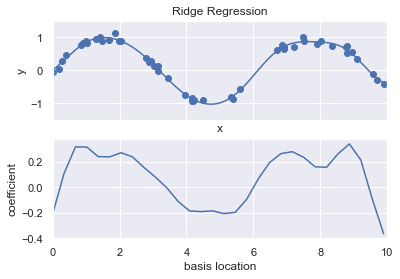

In [13]:
# 능선 회귀(L2 정규화)
# Ridge Regression, Tikhonov regularization
# 모델 계수의 제곱(2-norms)의 합에 패널티 부과 => introducing bias to reduce variance
# better for regrsesion with mostly relevant variables (obesity = a1*weight + a2*eating frequency ...)

from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title="Ridge Regression")

"""
a -> 0 일 때 표준 선형 회귀 결과
a -> infinity 일 때 모든 모델 응답이 억제
""";

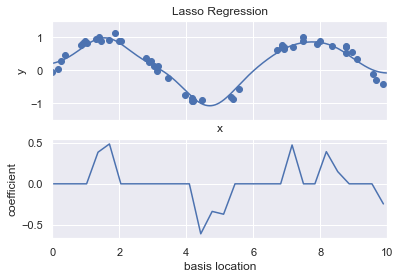

In [14]:
# 라쏘 정규화(L1), Lasso Regularization
# 회귀 계수의 절대값 (1-norm)의 합에 패널티를 부과
# 희박 모델을 선호, better for regression with silly variables (obesity = a1*weight + a2*religion ...)
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.01))
basis_plot(model, title="Lasso Regression")

# 사용 가능한 기저 함수의 일부만으로도 모델링 => 대부분의 계수가 정확히 0이 된다

In [15]:
# 예제: 자전거 통행량 예측
# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

import pandas as pd
counts = pd.read_csv("FremontBridge.csv", index_col="Date", parse_dates=True)
weather = pd.read_csv("BicycleWeather.csv", index_col="DATE", parse_dates=True)

In [16]:
# 일별 총 자전거 통행량을 계산해서 DataFrame에 추가
daily = counts.resample("d").sum()
daily = daily[["Fremont Bridge Total"]] # DataFrame
daily.columns = ["Total"]
daily.head()

,Total
Date,
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0
2012-10-07,2142.0


In [17]:
# 요일을 나타내는 이진 열 추가
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
    
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
# 휴일 표시자 추가
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays("2012", "2016") # DatetimeIndex for holidays between 2012 and 2016
daily = daily.join(pd.Series(1, index=holidays, name="holiday")) # join holidays (1 for holiday)
daily["holiday"].fillna(0, inplace=True) # replace NaN with 0 (not holiday)
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


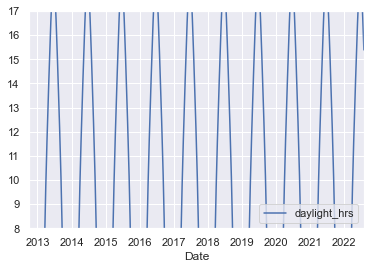

In [19]:
# 일조시간 정보 추가
from datetime import datetime as dt

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """해당 날짜의 일조시간 계산"""
    days = (date - dt(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) + np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily["daylight_hrs"] = list(map(hours_of_daylight, daily.index))
daily[["daylight_hrs"]].plot()
plt.ylim(8, 17);

In [20]:
# 평균 기온과 전체 강수량 추가

# 기온은 섭씨 1/10도 단위; 섭씨 1도 단위로 변환
weather["TMIN"] /= 10
weather["TMAX"] /= 10
weather["Temp (C)"] = 0.5 * (weather["TMIN"] + weather["TMAX"])

# 강수량은 1/10mm 단위; 인치 단위로 변환
weather["PRCP"] /= 254
weather["dry day"] = (weather["PRCP"] == 0).astype(int) # return 0 for False, 1 for True

daily = daily.join(weather[["PRCP", "Temp (C)", "dry day"]])
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.153079,0.0,13.35,1.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.799303,0.0,13.60,1.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.413133,0.0,15.30,1.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.984941,0.0,15.85,1.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.499074,0.0,15.85,1.0


In [21]:
# 첫날 부터 증가하는 계수기를 추가, 몇 해가 지낫는지 측정
daily["annual"] = (daily.index - daily.index[0]).days / 365.

daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.153079,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.799303,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.413133,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.984941,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.499074,0.0,15.85,1.0,0.010959


In [23]:
# 데이터가 준비되면 사용할 열을 선택해서 선형 회귀 모델을 데이터에 적합
# 요일 플래그는 근본적으로 해당 요일에 특화된 절편으로 동작, fit_intercept=False

# 널 값을 갖는 행은 모두 제거
daily.dropna(axis=0, how="any", inplace=True)

column_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "holiday",
                "daylight_hrs", "PRCP", "dry day", "Temp (C)", "annual"]

X = daily[column_names]
y = daily["Total"]

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

daily["predicted"] = model.predict(X)

daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Date,,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.153079,0.0,13.35,1.0,0.000000,3470.788480
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.799303,0.0,13.60,1.0,0.002740,3365.166042
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.413133,0.0,15.30,1.0,0.005479,3171.008021
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.984941,0.0,15.85,1.0,0.008219,1913.637266
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.499074,0.0,15.85,1.0,0.010959,1863.982372


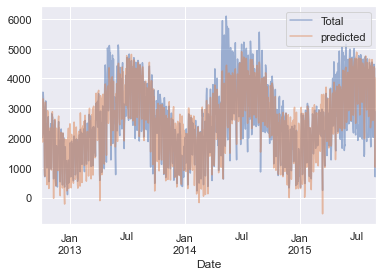

In [27]:
# 최종적으로 총 자전거 통행량과 예상 자전거 통행량을 비교
daily[["Total", "predicted"]].plot(alpha=0.5);

In [29]:
# 특징이 완전하지 않거나, 미처 고려하지 못한 비선형 관계 존재

params = pd.Series(model.coef_, index=X.columns)
params

# 불확실성에 대한 척도 없이 해석하기 어렵다

Mon             1642.496098
Tue             1748.411128
Wed             1732.527376
Thu             1622.201027
Fri             1317.569661
Sat               36.255968
Sun                5.509710
holiday        -1202.931765
daylight_hrs      39.051306
PRCP            -672.014002
dry day          551.571854
Temp (C)          73.816838
annual            23.773275
dtype: float64

In [32]:
# 부트스트랩 표본 재추출을 사용하여 불확실성 계산
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

print(pd.DataFrame({"effect": params.round(0), "error": err.round(0)}))

              effect  error
Mon           1642.0   61.0
Tue           1748.0   61.0
Wed           1733.0   61.0
Thu           1622.0   56.0
Fri           1318.0   59.0
Sat             36.0   53.0
Sun              6.0   52.0
holiday      -1203.0  171.0
daylight_hrs    39.0    3.0
PRCP          -672.0   65.0
dry day        552.0   34.0
Temp (C)        74.0    4.0
annual          24.0   18.0
